<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

In [ ]:
!nvidia-smi

Wed Sep 15 12:26:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.6.0


In [ ]:
!pip install -q tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 52 kB/s 
     |████████████████████████████████| 2.9 MB 36.4 MB/s 
     |████████████████████████████████| 20.1 MB 1.5 MB/s 
     |████████████████████████████████| 459 kB 30.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1388 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 27.13 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 7.5 MB 5.3 MB/s 
     |████████████████████████████████| 201 kB 23.3 MB/s 
     |████████████████████████████████| 15.7 MB 184 kB/s 
     |████████████████████████████████| 11.3 MB 22.3 MB/s 
     |████████████████████████████████| 296 kB 31.6 MB/s 
     |████████████████████████████████| 99 kB 6.2 MB/s 
     |████████████████████████████████| 28.5 MB 43 kB/s 
     |████████████████████████████████| 211 kB 40.6 MB/s 
     |████████████████████████████████| 4.0 MB 26.6 MB/s 
     |████████████████████████████████| 1.1 MB 33.5 MB/s 
     |████████████████████████████████| 352 kB 31.9 MB/s 
     |████████████████████████████████| 1.2 MB 43.0 MB/s 
     |████████████████████████████████| 10.3 MB 172 kB/s 
     |████████████████████████████████| 37.1 MB 50 kB/s 
     |████████████████████████████████| 636 kB 49.0 MB/s 
     |████████████████████████████████| 3.0 MB 37.6 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |██████████████

## Download and Import the Quora Insincere Questions Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',compression='zip',low_memory=False)
df.shape


(1306122, 3)

In [ ]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<AxesSubplot:title={'center':'Target Distribution'}, ylabel='Frequency'>

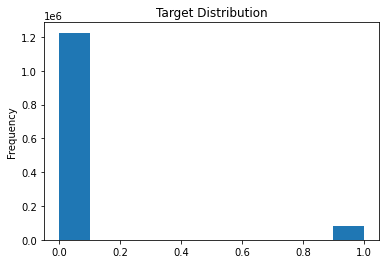

In [ ]:
df.target.plot(kind = 'hist',title="Target Distribution")

## Creating tf.data.Datasets for Training and Evaluation

In [ ]:
#Class Imbalance
train_df, remaining = train_test_split(df,random_state=42,train_size=0.0075,stratify=df.target.values)
valid_df,_ = train_test_split(remaining,random_state=42,train_size=0.00075,stratify = remaining.target.values)
train_df.shape,valid_df.shape

((9795, 3), (972, 3))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values,train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values,valid_df['target'].values))

  for text,label in train_data.take(1):
    print(text)
    print(label)
  

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## downloading a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list= [0,1] # Label categories
max_seq_length=128 # maximum length of (token) input sequences
train_batch_size=32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case)



In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hi, you are looking at my notebook :)')


['hi', '##,', 'you', 'are', 'looking', 'at', 'my', 'notebook', ':', '##)']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, you are looking at my notebook :)')
)

[7632, 29623, 2017, 2024, 2559, 2012, 2026, 14960, 1024, 29620]

## Tokenizing and Preprocessing Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(),text_b= None,label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0,example,label_list,max_seq_length,tokenizer)  
  return (feature.input_ids,feature.input_mask,feature.segment_ids,feature.label_id)
  

## Wrapping a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label],Tout = [tf.int32,tf.int32,tf.int32,tf.int32] )

  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  x={
      'input_word_ids': input_ids,
     'input_mask': input_mask,
     'input_type_ids': segment_ids
  }
  return (x, label_id)

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Adding a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,),dtype = tf.int32,name = "input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,),dtype = tf.int32,name = "input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,),dtype = tf.int32,name = "input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1,activation='sigmoid',name= 'output')(drop)
  model = tf.keras.Model(
      inputs = {
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs = output
  )
  return model

## Fine-Tuning BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
 loss = tf.keras.losses.BinaryCrossentropy(),
 metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

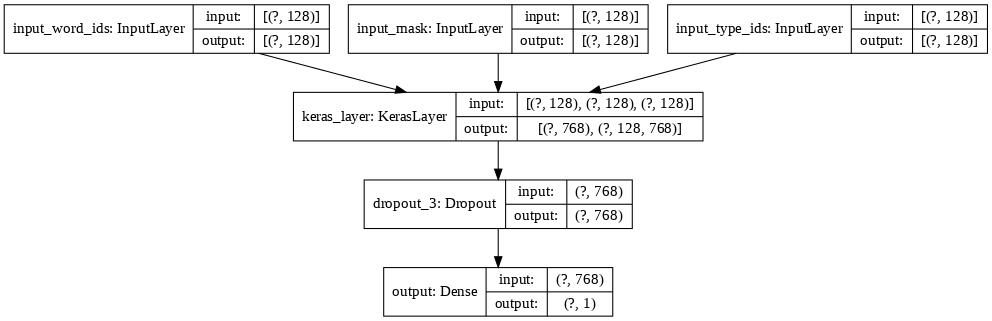

In [ ]:
tf.keras.utils.plot_model(model=model,show_shapes=True, dpi =76)

In [ ]:
# Train model
epochs = 4
history = model.fit(train_data,validation_data=valid_data,epochs=epochs,verbose=1)

Epoch 1/4
306/306 [==============================] - ETA: 0s - loss: 0.1628 - binary_accuracy: 0.9418WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0624s vs `on_test_batch_end` time: 0.4679s). Check your callbacks.


306/306 [==============================] - 472s 2s/step - loss: 0.1628 - binary_accuracy: 0.9418 - val_loss: 0.1141 - val_binary_accuracy: 0.9573
Epoch 2/4
306/306 [==============================] - 468s 2s/step - loss: 0.0999 - binary_accuracy: 0.9618 - val_loss: 0.1278 - val_binary_accuracy: 0.9552
Epoch 3/4
306/306 [==============================] - 466s 2s/step - loss: 0.0477 - binary_accuracy: 0.9839 - val_loss: 0.1434 - val_binary_accuracy: 0.9573
Epoch 4/4
306/306 [==============================] - 466s 2s/step - loss: 0.0182 - binary_accuracy: 0.9942 - val_loss: 0.2170 - val_binary_accuracy: 0.9625


## Evaluating the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

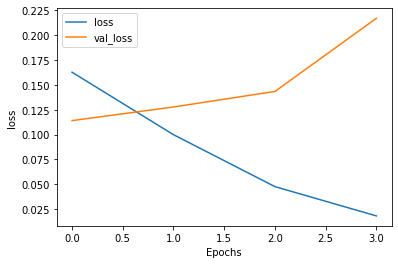

In [ ]:
plot_graphs(history,'loss')

In [ ]:
# We can observe overfitting

In [ ]:
sample_example = ["What are you doing?","Are you ashamed of being Indian?"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.0005
['Insincere' if pred>=threshold else 'Sincere ' for pred in preds]


['Sincere ', 'Insincere']